<a href="https://colab.research.google.com/github/Sihamtahi/DeepL-NoteBooks/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np
from  matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


In [3]:
num_units = 10
embedding_dim = 2
dropout = .1
recurrent_dropout = .1

In [4]:
def simu_data(sample_per_group=15000):
    time = np.stack([np.arange(10)]*sample_per_group, axis=0).astype(np.float32)
    time = np.pi / 2 * time + np.random.uniform(low=-4, high=4, size=[sample_per_group, 1])
    group_a = 5*np.sin(time) + 10 + np.random.normal(0, 1, size=[sample_per_group, 10])
    group_b = 10 + np.random.normal(0, 1, size=[sample_per_group, 10])
    X = np.concatenate([group_a, group_b])
    y = np.concatenate([
        np.zeros(dtype=np.int32, shape=sample_per_group),
        np.ones(dtype=np.int32, shape=sample_per_group)
    ])
    shuffling = np.arange(sample_per_group * 2)
    np.random.shuffle(shuffling)
    X = X[shuffling]
    y = y[shuffling]
    return X, y

In [5]:
def my_encoder(my_inputs):
    encoder_RNN = tf.keras.layers.LSTM(num_units, dropout=dropout, recurrent_dropout=recurrent_dropout)
    encoder_linear = tf.keras.layers.Dense(embedding_dim)
    encoder_RNN_out = encoder_RNN(my_inputs)
    return encoder_linear(encoder_RNN_out)


In [6]:
def my_decoder(embedded_vector, my_shifted_inputs):
    
    decoder_RNN = tf.keras.layers.LSTM(
        num_units,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        return_sequences=True
    )
    decoder_linear = tf.keras.layers.Dense(num_units)
    predictor = tf.keras.layers.Dense(1)
    decoder_initial_state = decoder_linear(embedded_vector)
    decoder_RNN_out = decoder_RNN(
        my_shifted_inputs,
        initial_state=[decoder_initial_state, tf.keras.backend.zeros_like(decoder_initial_state)]
    )
    return predictor(decoder_RNN_out)

Epoch 1/25
750/750 [==============================] - 12s 12ms/step - loss: 25.9623 - val_loss: 8.0242
Epoch 2/25
750/750 [==============================] - 8s 11ms/step - loss: 7.7067 - val_loss: 7.7888
Epoch 3/25
750/750 [==============================] - 8s 11ms/step - loss: 7.6485 - val_loss: 7.7359
Epoch 4/25
750/750 [==============================] - 8s 11ms/step - loss: 7.3902 - val_loss: 7.2203
Epoch 5/25
750/750 [==============================] - 8s 11ms/step - loss: 6.6447 - val_loss: 5.9966
Epoch 6/25
750/750 [==============================] - 8s 11ms/step - loss: 5.6553 - val_loss: 4.7836
Epoch 7/25
750/750 [==============================] - 9s 11ms/step - loss: 4.8632 - val_loss: 3.3660
Epoch 8/25
750/750 [==============================] - 8s 11ms/step - loss: 4.1235 - val_loss: 2.5716
Epoch 9/25
750/750 [==============================] - 9s 11ms/step - loss: 3.5744 - val_loss: 2.0999
Epoch 10/25
750/750 [==============================] - 8s 11ms/step - loss: 3.0455 - val_

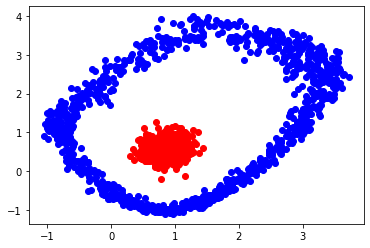

In [8]:
x, y = simu_data()

group_a = x[np.argwhere(y == 0).flatten()]
group_b = x[np.argwhere(y == 1).flatten()]
X_in = tf.keras.Input(shape=[10])
inputs = tf.expand_dims(X_in, axis=-1)

shifted_inputs = tf.pad(inputs, [[0, 0], [1, 0], [0, 0]], constant_values=0.)[:, :-1]

embedded_vector = my_encoder(inputs)
decoded_sequences = my_decoder(embedded_vector, shifted_inputs)

encoder = tf.keras.Model(inputs=X_in, outputs=embedded_vector)

autoencoder = tf.keras.Model(inputs=X_in, outputs=decoded_sequences)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.fit(x, x, epochs=25, shuffle=True, validation_split=.2)#####il faut changer ici le nombre d'epochs à 50

"""predictions = autoencoder.predict(x)
pred_a = predictions[np.argwhere(y == 0).flatten()]
pred_b = predictions[np.argwhere(y == 1).flatten()]

plt.plot(pred_a[:500, :, 0].transpose(), color='blue')
plt.plot(pred_b[:500, :, 0].transpose(), color='red')
plt.scatter(pred_a[:1000, 0], pred_a[:1000, 1], color="blue")
plt.scatter(pred_b[:1000, 0], pred_b[:1000, 1], color="red")
"""
my_embedded_vectors = encoder.predict(x)
embedded_a = my_embedded_vectors[np.argwhere(y == 0).flatten()]
embedded_b = my_embedded_vectors[np.argwhere(y == 1).flatten()]
plt.scatter(embedded_a[:1000, 0], embedded_a[:1000, 1], color="blue")
plt.scatter(embedded_b[:1000, 0], embedded_b[:1000, 1], color="red")